# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

### Not for Grading: Self Learning

## What neurons do?

In [1]:
#@title Case Study Walkthrough
#@markdown  What neurons do?
from IPython.display import HTML

HTML("""<video width="320" height="240" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_2018_b7_hyd/preview_videos/what_neurons_do.mp4">
</video>
""")



The objective of the experiment is to understand how the changes in neurons of MLP layers affect the decision boundary.



## Setup Steps

In [2]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "aiml_pg_25" #@param {type:"string"}


In [3]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "4521452411" #@param {type:"string"}


In [4]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "U2W7_CS_What_neurons_do" #name of the notebook
Answer = "Ungraded"
def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    ipython.magic("sx wget -qq https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Penguin.csv")
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():

    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts() and getComments():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "id" : Id, "file_hash" : file_hash,
              "feedback_experiments_input" : Comments, "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://learn-iiith.talentsprint.com/notebook_submissions")
        # print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()

else:
  print ("Please complete Id and Password cells before running setup")


Setup completed successfully


## Importing required packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset we can play with. Here, we will use [scikit-learn](http://scikit-learn.org/) package which has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

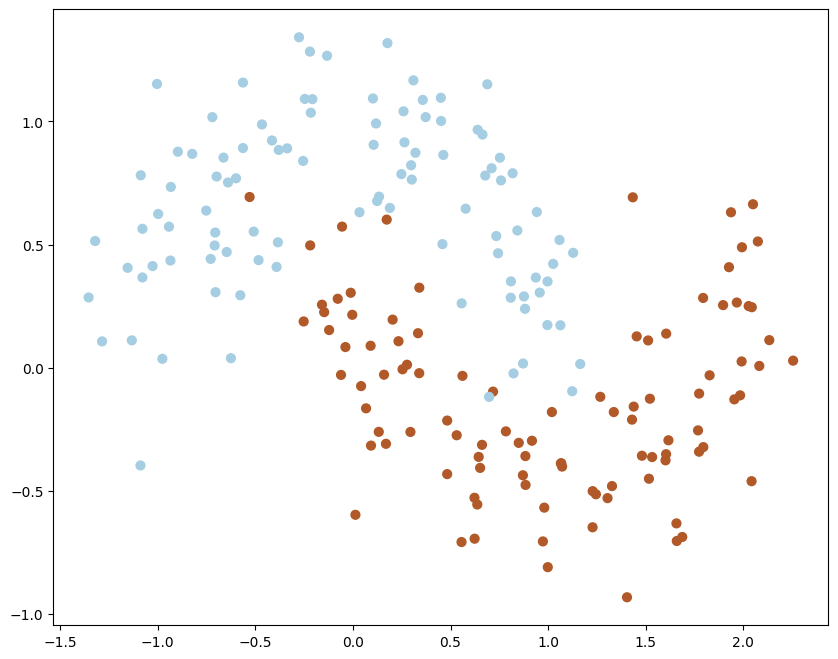

In [6]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Paired)

In [7]:
#@title Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.BrBG)

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [8]:
# MLP parameters
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [9]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [10]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [11]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))

    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.603423
Loss after iteration 1000: 0.069201
Loss after iteration 2000: 0.071296
Loss after iteration 3000: 0.071348
Loss after iteration 4000: 0.071370
Loss after iteration 5000: 0.071380
Loss after iteration 6000: 0.071383
Loss after iteration 7000: 0.071383
Loss after iteration 8000: 0.071381
Loss after iteration 9000: 0.071377
Loss after iteration 10000: 0.071374
Loss after iteration 11000: 0.071370
Loss after iteration 12000: 0.071366
Loss after iteration 13000: 0.071363
Loss after iteration 14000: 0.071360
Loss after iteration 15000: 0.071357
Loss after iteration 16000: 0.071355
Loss after iteration 17000: 0.071352
Loss after iteration 18000: 0.071350
Loss after iteration 19000: 0.071348


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

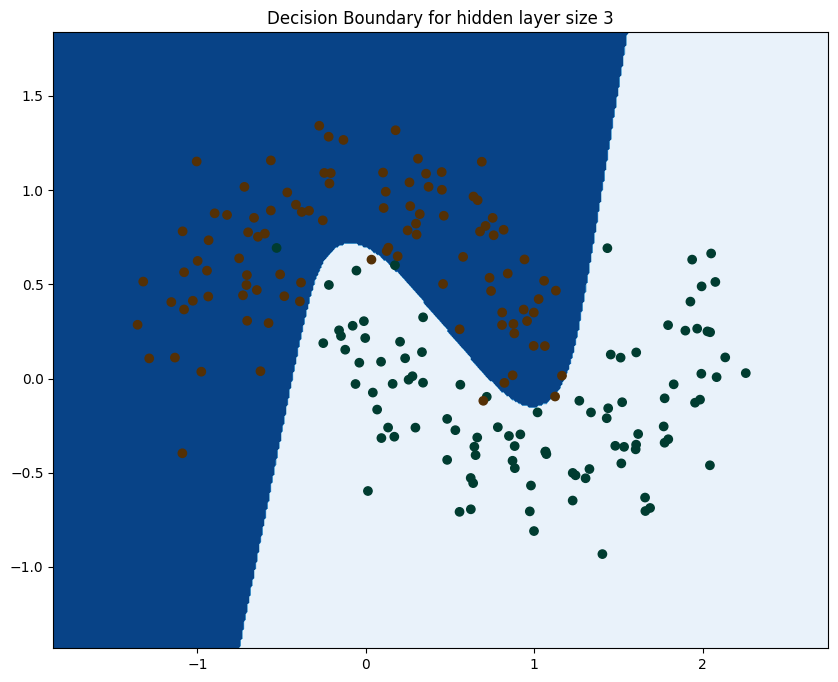

In [12]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Here, our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.



As the number of neurons in the hidden increases the complexity of the decision boundary increases and we can visualize in the following plots

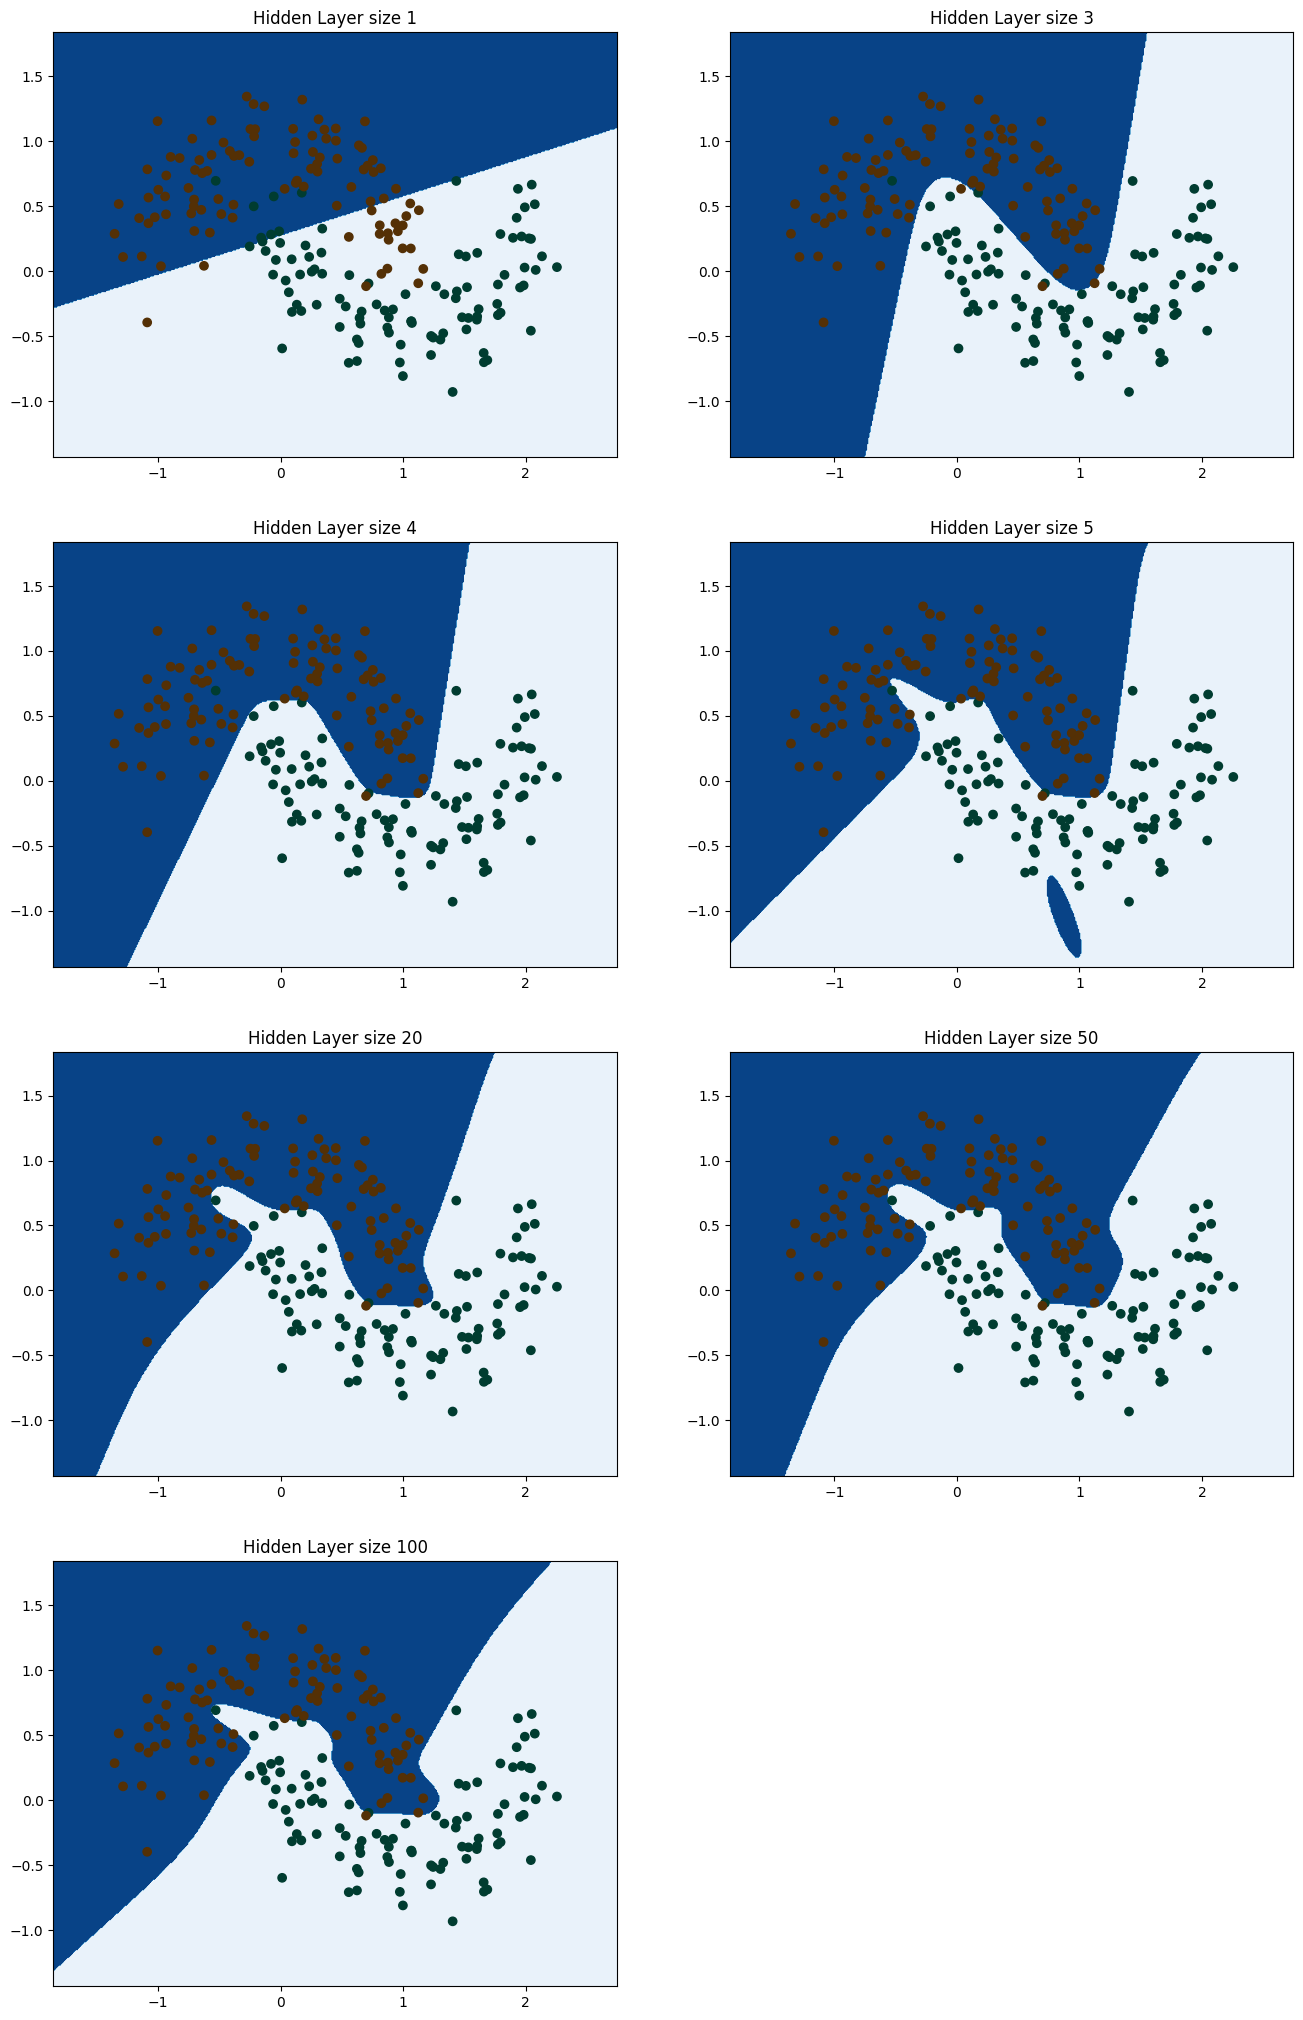

In [13]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 3, 4, 5, 20, 50, 100]
models=[]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    models.append(model)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

## Please answer the questions below to complete the experiment:

In [14]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [15]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "sdgfdjhfgjfhjh" #@param {type:"string"}

In [16]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]

In [17]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Somewhat Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [18]:
#@title Run this cell to submit your notebook  { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 3966
Date of submission:  16 Jun 2025
Time of submission:  02:33:40
View your submissions: https://learn-iiith.talentsprint.com/notebook_submissions
